# Fine Tuning of Pretrained VGG16 Pytorch Model On Fruits-360 Dataset
Author: Swapnali Gujar
This notebook is developed to read weights of pre-trained PyTorch Model VGG16 and fine tune it using Fruits 360 dataset.

In [0]:
pip install torchinfo

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data.dataloader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple,Dict,List
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
import random
from pathlib import Path
import csv
import os
import torch
import torch.nn.functional as F

# Display cluster configuration

In [0]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [0]:
trn_data = datasets.ImageFolder(train_dir)
image_paths = [trn_data.imgs[i][0] for i in range(len(trn_data))]

In [0]:
image_paths[0]

'/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Training/Apple 6/r0_0_100.jpg'

# Define dataloader and class_names

In [0]:

def create_dataloaders(
    train_dir:str,
    test_dir:str,
    train_transforms:transforms.Compose,
    test_transforms:transforms.Compose,
    batch_size:int,
    num_workers:int=2
):
    #select all image and implement selected transform and turn into tensor
    train_data=datasets.ImageFolder(train_dir,transform=train_transforms)
    test_data=datasets.ImageFolder(test_dir,transform=test_transforms)

    #ImageFolder class have a variable about folder names under the selected path
    class_names=train_data.classes


    train_dataloader=DataLoader(
        train_data,
        batch_size=batch_size, #how many image should select in each iter
        shuffle=True, #mix the data
        num_workers=num_workers,
        pin_memory=True
    )

    test_dataloader=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader,test_dataloader,class_names

# Display an image before and after augmentation

In [0]:
#path: /Volumes/cmidev/default/preventech/data/user_files/gf591/ML/fruits-360/Training/
data_path=Path("/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/")
train_dir=data_path /"Training"
test_dir=data_path /"Test"


In [0]:
test_dir

PosixPath('/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test')

# Original Image

/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Training/Walnut 1/1_100.jpg


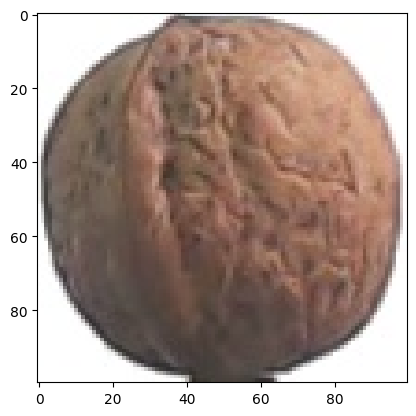

In [0]:
import torch  
import matplotlib.pyplot as plt  
import numpy as np  
# im = os.path.join(train_dir,'Apple 6/r0_0_100.jpg')
im = os.path.join(train_dir,'Walnut 1/1_100.jpg')

print(im)
img=Image.open(im)
# Get the first batch of images from the dataloader  
# images, labels = next(iter(train_dataloader))  
# print(labels)
# Select the first image in the batch  
# image = images[4]  
  
# Convert the PyTorch tensor to a numpy array  
# image = np.transpose(img.numpy(), (1, 2, 0))  
  
# Plot the image  
plt.imshow(img)  
plt.show()  

# Image Augmentation

In [0]:
# Define the settings for the ImageClassification transform  
from torchvision.transforms import InterpolationMode 
crop_size = [224]  
resize_size = [256]  
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]  
interpolation = InterpolationMode.BILINEAR  
  
# Create the test_transform  
test_transform = transforms.Compose([  
    transforms.Resize(resize_size, interpolation=interpolation),  
    transforms.CenterCrop(crop_size),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=mean, std=std)  
])  


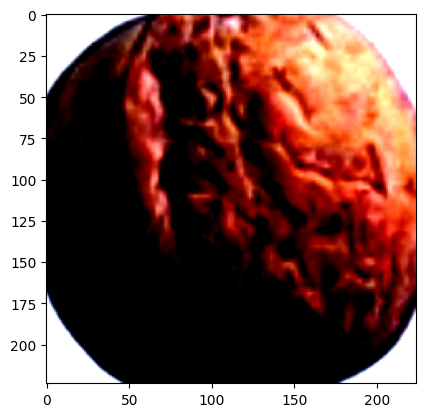

In [0]:
transformed_image = test_transform(img)  

image = np.transpose(transformed_image.numpy(), (1, 2, 0))  
  
# Plot the image  
plt.imshow(image)  
plt.show()  
plt.show()  

tensor([100,  69,  97,  67, 133,  76, 138,  60, 102,  62,  30,  87, 103,  93,
        138,  95,  50, 107, 137,  14, 108,  87,  20, 131,  26,  52,  51,  84,
        105, 115,  95, 104])


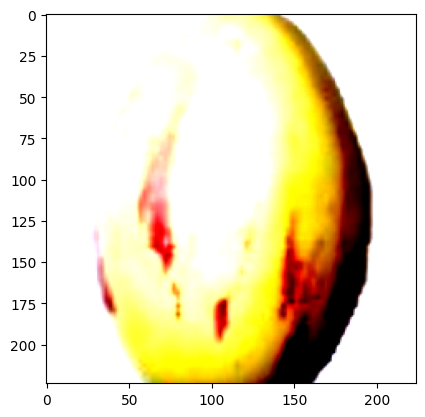

In [0]:
# Get the first batch of images from the dataloader  
images, labels = next(iter(train_dataloader))  
print(labels)
# Select the first image in the batch  
image = images[0]  
  
# Convert the PyTorch tensor to a numpy array  
image = np.transpose(image.numpy(), (1, 2, 0))  
  
# Plot the image  
plt.imshow(image)  
plt.show()  

In [0]:
# train = datasets.ImageFolderdatasets.ImageFolder
# 
# (train_dir)
# image_paths = [test_data.imgs[i][0] for i in range(len(train))]

# Get the pretrained model

In [0]:
weights=torchvision.models.VGG16_Weights.DEFAULT

auto_transforms=weights.transforms()

train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir=train_dir,
                                                                test_dir=test_dir,
                                                                train_transforms=auto_transforms,
                                                                test_transforms=auto_transforms,
                                                                batch_size=32)
model_vgg16=torchvision.models.vgg16(weights=weights)
for param in model_vgg16.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 92.5MB/s]


In [0]:
len(class_names)

141

In [0]:
# model=torchvision.models.googlenet(weights=weights)
# for param in model.parameters():
#     param.requires_grad = False

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 48.9MB/s]


# Model Summary before fine tuning

In [0]:
from torchinfo import summary
summary(model=model_vgg16,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

/databricks/python/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (6)

# Baseline:
Below model is to modify the fully connected (fc) layer of a pre-trained GoogleNet model in PyTorch by adding layers as below:
1. First layer is added to the sequential module with 1024 input features and 512 output features.
2. To reduce non-linearity and improve learning of model on complex patterns, a ReLu activation function is added in second layer to act on the output of the first layer
3. Third layer is added with drop out to reduce overfitting of the model by randomly dropping out some of the neurons during training for regularization.
4. Forth layer is added to generate output having total classes = number of classes in original dataset.
5. Last layer is added to take Log of SoftMax function on probability of the prediction belonging to each class.
By doing this, in this baseline model is  replacing the original fc layer of the pre-trained GoogleNet model with the new sequential module. 

In [0]:
model_vgg16.fc = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(512, len(class_names)),
                                 nn.LogSoftmax(dim=1)).to(device)

# Model Compilation: Loss function and optimizer

In [0]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(params=model_vgg16.parameters(),lr=0.001)


# Define functions for model training

In [0]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch,(image,label) in enumerate(data_loader):
        image,label=image.to(device),label.to(device)
        
        y_pred=model(image)
        
        loss=loss_fn(y_pred,label)
        
        train_loss+=loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc +=(y_pred_class==label).sum().item()/len(y_pred)
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader) 
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device =device): 
    test_loss,test_acc=0,0
    
    model.eval()
    with torch.inference_mode():
        for batch,(image,label) in enumerate(data_loader):
            image,label=image.to(device),label.to(device)
            
            test_pred_logits=model(image)
            
            loss=loss_fn(test_pred_logits,label)
            test_loss += loss.item()
            
            test_pred_labels=test_pred_logits.argmax(dim=1)
            
            test_acc+= ((test_pred_labels==label).sum().item()/len(test_pred_labels))
            
        test_loss/=len(data_loader)
        test_acc/=len(data_loader)
    return test_loss,test_acc   

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs:int=5,
          device=device):
    results={"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
        test_loss,test_acc=test_step(model=model,
                                       data_loader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        print(f"Epoch:{epoch}| train_loss:{train_loss:.4f}|train_acc:{train_acc:.4f}|test_loss:{test_loss:.4f}|test_acc:{test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results


# Update gradient for backpropagation and optimization of the model during training

In [0]:
%python
model_vgg16 = model_vgg16.requires_grad_(True)

# Initial training with 5 epochs

In [0]:
# from timeit import default_timer as timer
# start_time=timer()
# device = "cuda" if torch.cuda.is_available() else "cpu"
# results=train(model=model_vgg16,
#                     train_dataloader=train_dataloader,
#                     test_dataloader=test_dataloader,
#                     optimizer=optimizer,
#                     loss_fn=loss_fn,
#                     epochs=15,
#                     device=device)
# end_time=timer()
# print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

# # 5/5 [25:16<00:00, 302.51s/it]
# # Epoch:0| train_loss:1.3318|train_acc:0.6648|test_loss:0.4805|test_acc:0.8802
# # Epoch:1| train_loss:0.1989|train_acc:0.9445|test_loss:0.4788|test_acc:0.8906
# # Epoch:2| train_loss:0.1680|train_acc:0.9587|test_loss:0.5093|test_acc:0.9036
# # Epoch:3| train_loss:0.1230|train_acc:0.9700|test_loss:0.3074|test_acc:0.9271
# #[INFO]Total training time= 1516.539 seconds

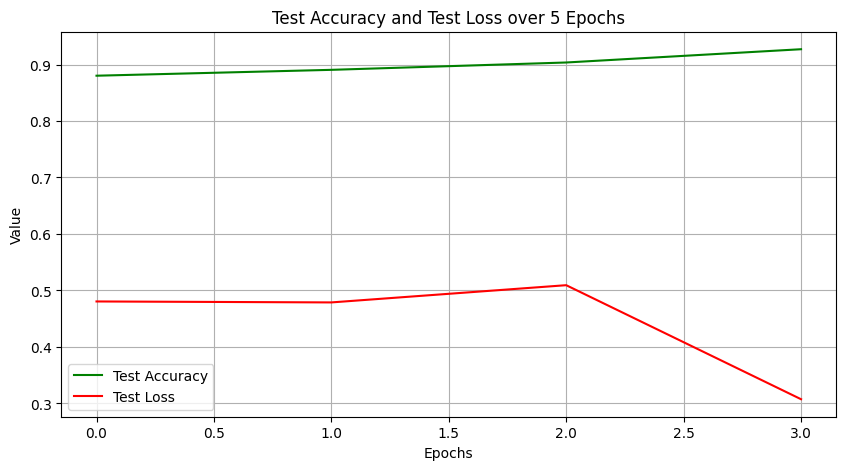

In [0]:
import matplotlib.pyplot as plt

# Extract test accuracy and test loss from results
test_acc = [0.8802,0.8906,0.9036,0.9271]
test_loss = [0.4805,0.4788,0.5093,0.3074]
epochs = range(len(test_acc))

# Plot test accuracy and test loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_acc, 'g-', label='Test Accuracy')
plt.plot(epochs, test_loss, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Test Accuracy and Test Loss over 5 Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Further training wiht 15 epochs

In [0]:
from timeit import default_timer as timer
import torch

start_time = timer()
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the appropriate device
model_vgg16 = model_vgg16.to(device)

results = train(
    model=model_vgg16,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=15,
    device=device
)

end_time = timer()
print(f"[INFO]Total training time= {end_time - start_time:.3f} seconds")
# Epoch:0| train_loss:1.2015|train_acc:0.7009|test_loss:0.4702|test_acc:0.8867
# Epoch:1| train_loss:0.1885|train_acc:0.9478|test_loss:0.4381|test_acc:0.8975
# Epoch:2| train_loss:0.1645|train_acc:0.9600|test_loss:0.5363|test_acc:0.8997
# Epoch:3| train_loss:0.1194|train_acc:0.9716|test_loss:0.4650|test_acc:0.8967
# Epoch:4| train_loss:0.0990|train_acc:0.9772|test_loss:0.6109|test_acc:0.8721
# Epoch:5| train_loss:0.0820|train_acc:0.9815|test_loss:0.6963|test_acc:0.8942
# Epoch:6| train_loss:0.1222|train_acc:0.9778|test_loss:0.4919|test_acc:0.9150
# Epoch:7| train_loss:0.0584|train_acc:0.9876|test_loss:0.3797|test_acc:0.9400
# Epoch:8| train_loss:0.2271|train_acc:0.9811|test_loss:0.4480|test_acc:0.9265
# Epoch:9| train_loss:0.0706|train_acc:0.9872|test_loss:0.3646|test_acc:0.9384
# Epoch:10| train_loss:0.0642|train_acc:0.9876|test_loss:0.4740|test_acc:0.9353
# Epoch:11| train_loss:0.0652|train_acc:0.9888|test_loss:0.4695|test_acc:0.9385
# Epoch:12| train_loss:0.0939|train_acc:0.9845|test_loss:0.4263|test_acc:0.9425
# Epoch:13| train_loss:0.0794|train_acc:0.9882|test_loss:0.4958|test_acc:0.9208
# Epoch:14| train_loss:0.0806|train_acc:0.9867|test_loss:0.8175|test_acc:0.9180
# [INFO]Total training time= 15019.803 seconds

  0%|          | 0/15 [00:00<?, ?it/s]

/databricks/python/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch:0| train_loss:1.2015|train_acc:0.7009|test_loss:0.4702|test_acc:0.8867
Epoch:1| train_loss:0.1885|train_acc:0.9478|test_loss:0.4381|test_acc:0.8975
Epoch:2| train_loss:0.1645|train_acc:0.9600|test_loss:0.5363|test_acc:0.8997
Epoch:3| train_loss:0.1194|train_acc:0.9716|test_loss:0.4650|test_acc:0.8967
Epoch:4| train_loss:0.0990|train_acc:0.9772|test_loss:0.6109|test_acc:0.8721
Epoch:5| train_loss:0.0820|train_acc:0.9815|test_loss:0.6963|test_acc:0.8942
Epoch:6| train_loss:0.1222|train_acc:0.9778|test_loss:0.4919|test_acc:0.9150
Epoch:7| train_loss:0.0584|train_acc:0.9876|test_loss:0.3797|test_acc:0.9400
Epoch:8| train_loss:0.2271|train_acc:0.9811|test_loss:0.4480|test_acc:0.9265
Epoch:9| train_loss:0.0706|train_acc:0.9872|test_loss:0.3646|test_acc:0.9384
Epoch:10| train_loss:0.0642|train_acc:0.9876|test_loss:0.4740|test_acc:0.9353
Epoch:11| train_loss:0.0652|train_acc:0.9888|test_loss:0.4695|test_acc:0.9385
Epoch:12| train_loss:0.0939|train_acc:0.9845|test_loss:0.4263|test_acc:0.9

Note: Originally model was trained for 5 epochs to evaluate it's performance. Then it is trained for 15 epochs. Below plot shows its performance. After that, by saving model file and model weights, it was further trained for 10 more epochs. However, it was found that model performance plateaued. So we did not save that model file for further inferencing.

Training further for 10 more epochs, previous trained model and its weights were saved to the disk previously and loaded to train further 

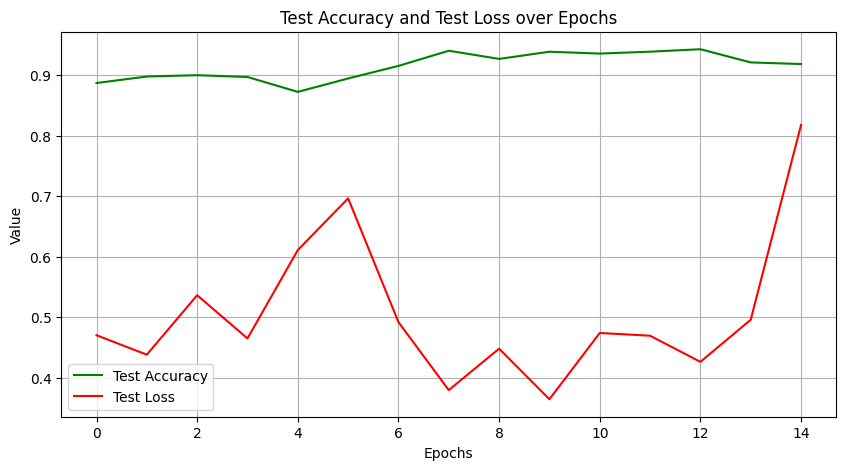

In [0]:
import matplotlib.pyplot as plt

# Extract test accuracy and test loss from results
test_acc = results['test_acc']
test_loss = results['test_loss']
epochs = range(len(test_acc))

# Plot test accuracy and test loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_acc, 'g-', label='Test Accuracy')
plt.plot(epochs, test_loss, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Test Accuracy and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [0]:
test_acc.extend(results['test_acc'])  
test_loss.extend(results['test_loss'])  


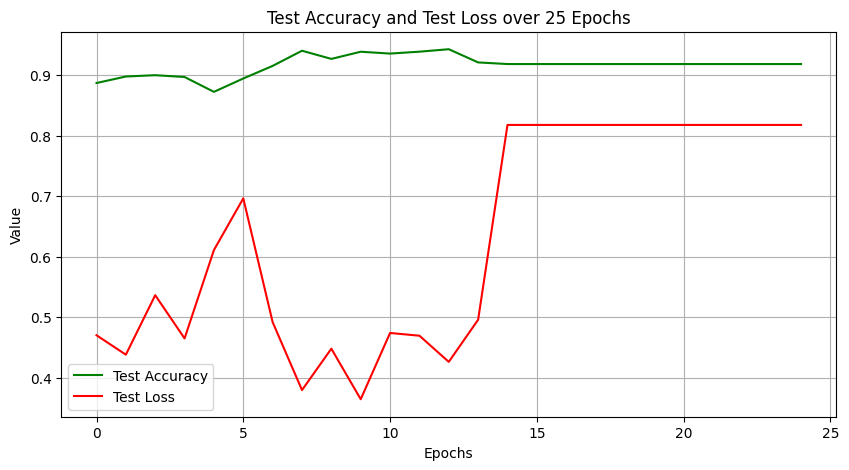

In [0]:
import matplotlib.pyplot as plt

# Extract test accuracy and test loss from results
# test_acc = results['test_acc']
# test_loss = results['test_loss']
epochs = range(len(test_acc))

# Plot test accuracy and test loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_acc, 'g-', label='Test Accuracy')
plt.plot(epochs, test_loss, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Test Accuracy and Test Loss over 25 Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [0]:
best_accuracy = np.max(test_acc)  
best_epoch = test_acc.index(best_accuracy)

print("best_epoch:", best_epoch, "best_accuracy:", best_accuracy)


best_epoch: 12 best_accuracy: 0.9425321380243572


In [0]:
best_accuracy = np.max(test_acc)  
best_epoch = test_acc.index(best_accuracy)

print("best_epoch:", best_epoch, "best_accuracy:", best_accuracy)

best_epoch: 12 best_accuracy: 0.9425321380243572


# Save model that was trained with 15 epochs

In [0]:
# specify the path to save the model  
model_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/model_vgg16_finetuned_15epochs.pth'  
  
# save the model  
# torch.save(model_vgg16.state_dict(), model_path)  
# Save the state of the model and optimizer  
torch.save({  
    'epoch': 12,  
    'model_state_dict': model_vgg16.state_dict(),  
    'optimizer_state_dict': optimizer.state_dict(),  
    'loss': test_loss[best_epoch],  
    'accuracy': np.max(test_acc),  
}, model_path)  

# Save model weights

In [0]:
# specify the path to save the weights  
weights_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/model_vgg16_finetuned_weights_15epochs.pth'  
  
# get the state dict of the model  
model_weights = model_vgg16.state_dict()  
  
# save the weights  
torch.save(model_weights, weights_path)  

In [0]:
len(np.unique(class_names))

141

In [0]:
%python
import torch
import torchvision.models as models
import numpy as np

# Assuming class_names is defined somewhere in your code
# num_classes = len(np.unique(class_names))  
num_classes =141
# Define the model architecture  
model_vgg16 = models.vgg16(pretrained=True)  

# Modify the last layer to match the number of classes in your dataset  
model_vgg16.classifier[6] = torch.nn.Linear(model_vgg16.classifier[6].in_features, num_classes)  

# model_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/model_vgg16_finetuned.pth'

model_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/model_vgg16_finetuned_15epochs.pth' 

# Load the saved model and its weights  
checkpoint = torch.load(model_path)

# Update the state_dict keys to match the modified model architecture
state_dict = checkpoint['model_state_dict']
state_dict = {k.replace("classifier.6", "classifier.6"): v for k, v in state_dict.items()}

# Remove unexpected keys from the state_dict
state_dict = {k: v for k, v in state_dict.items() if k in model_vgg16.state_dict()}

# Resize the weights and biases of the last layer in the checkpoint to match the modified model
state_dict['classifier.6.weight'] = state_dict['classifier.6.weight'][:num_classes, :]
state_dict['classifier.6.bias'] = state_dict['classifier.6.bias'][:num_classes]

# Load the modified state_dict into the model
model_vgg16.load_state_dict(state_dict, strict=False)

# Set the model to evaluation mode  
model_vgg16.eval()

/databricks/python/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Model Summary after fine tuning

In [0]:
from torchinfo import summary
summary(model=model_vgg16,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

/databricks/python/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 141]            --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [0]:
def create_image_dataloaders(  
    train_dir:str,  
    test_dir:str,  
    train_transforms:transforms.Compose,  
    test_transforms:transforms.Compose,  
    batch_size:int,  
    num_workers:int=2  
):  
    #select all image and implement selected transform and turn into tensor  
    train_data=datasets.ImageFolder(train_dir,transform=train_transforms)  
    test_data=datasets.ImageFolder(test_dir,transform=test_transforms)  
  
    #ImageFolder class have a variable about folder names under the selected path  
    class_names=train_data.classes  
  
    # Get a list of image paths for the test data  
    test_image_paths = [os.path.join(test_data.root, path) for path in test_data.imgs]  
  
    # Create the dataloaders  
    train_dataloader=DataLoader(  
        train_data,  
        batch_size=batch_size,  
        shuffle=True,  
        num_workers=num_workers,  
        pin_memory=True  
    )  
  
    test_dataloader=DataLoader(  
        test_data,  
        batch_size=batch_size,  
        shuffle=False,  
        num_workers=num_workers,  
        pin_memory=True  
    )  
  
    # Create a new TestDataset class to include image paths in the test dataloader  
    class TestDataset(Dataset):  
        def __init__(self, data, image_paths):  
            self.data = data  
            self.image_paths = image_paths  
  
        def __getitem__(self, index):  
            img, label = self.data[index]  
            path = self.image_paths[index]  
            return img, label, path  
  
        def __len__(self):  
            return len(self.data)  
  
    # Replace the test dataloader with a new TestDataset object that includes image paths  
    test_dataloader = DataLoader(  
        TestDataset(test_data, test_image_paths),  
        batch_size=batch_size,  
        shuffle=False,  
        num_workers=num_workers,  
        pin_memory=True  
    )  
  
    return train_dataloader,test_dataloader,class_names  

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:730)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:448)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:448)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

# Display data augmentation transform

In [0]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [0]:
%python
weights_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/model_vgg16_finetuned_weights_15epochs.pth'
# auto_transforms=weights.transforms()
# Load the saved weights into the model instance  
# Define the settings for the ImageClassification transform 
from torchvision.transforms import InterpolationMode 
crop_size = [224]  
resize_size = [256]  
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]  
interpolation = InterpolationMode.BILINEAR  
  
# Create the test_transform  
test_transform = transforms.Compose([  
    transforms.Resize(resize_size, interpolation=interpolation),  
    transforms.CenterCrop(crop_size),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=mean, std=std)  
])  
 
# transforms = torch.load(transforms_path)  
my_weights = torch.load(weights_path)  

# Load the saved weights into the model instance  
# model_vgg16.load_state_dict(my_weights)  
  
# Apply the saved transforms to the model instance  
# auto_transforms = transforms(model_vgg16) 

def create_image_dataloaders(train_dir, test_dir, train_transforms, test_transforms, batch_size, num_workers=4):
    # Assuming the function implementation is correct
    train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    class_names = train_data.classes
    
    # Get a list of image paths for the test data
    test_image_paths = [os.path.join(test_data.root, path[0]) for path in test_data.imgs]
    return train_dataloader, test_dataloader, class_names, test_image_paths

train_dataloader, test_dataloader, class_names, test_image_paths = create_image_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=test_transform,
    test_transforms=test_transform,
    batch_size=32
)
    
    # return train_dataloader, test_dataloader, class_names

# train_dataloader, test_dataloader, class_names = create_image_dataloaders(
#     train_dir=train_dir,
#     test_dir=test_dir,
#     train_transforms=test_transform,
#     test_transforms=test_transform,
#     batch_size=32
# )

In [0]:
(test_image_paths[7895])

'/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Granadilla 1/325_100.jpg'

In [0]:
class_names

['Apple 6',
 'Apple Braeburn 1',
 'Apple Crimson Snow 1',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith 1',
 'Apple Pink Lady 1',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious 1',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apple hit 1',
 'Apricot 1',
 'Avocado 1',
 'Avocado ripe 1',
 'Banana 1',
 'Banana Lady Finger 1',
 'Banana Red 1',
 'Beetroot 1',
 'Blueberry 1',
 'Cabbage white 1',
 'Cactus fruit 1',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula 1',
 'Carrot 1',
 'Cauliflower 1',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier 1',
 'Cherry Wax Black 1',
 'Cherry Wax Red 1',
 'Cherry Wax Yellow 1',
 'Chestnut 1',
 'Clementine 1',
 'Cocos 1',
 'Corn 1',
 'Corn Husk 1',
 'Cucumber 1',
 'Cucumber 3',
 'Cucumber Ripe 1',
 'Cucumber Ripe 2',
 'Dates 1',
 'Eggplant 1',
 'Eggplant long 1',
 'Fig 1',
 'Ginger Root 1',
 'Granadilla 1',
 'Grape Blue 1',
 'Grape Pink 1',
 'Grape White 1',
 'Grape White 2',
 'Grape White 3',
 'Grape White

In [0]:
# len(test_data),len(image_paths)

(23619, 23619)

# Use model for inference and store predictions in a csv file

In [0]:
%python
import csv
import torch

# specify the path to save the results
results_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/test_results_vgg16_finetuned_2.csv'

# create a list to store the results
results = []

# move the model to the device
model_vgg16.to(device)
# set the model to evaluation mode
model_vgg16.eval()
count=0
# iterate over the test dataset
# for (inputs, labels) in test_dataloader:
for (inputs, labels)  in (test_dataloader):
    count +=1
    # move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # paths = paths.to(device)

    # forward pass
    outputs = model_vgg16(inputs)
    _, predicted = torch.max(outputs, 1)

    print(len(inputs))
    # append the results to the list
    for i in range(len(inputs)):
        # print(image_paths[i],labels[i].item(), predicted[i].item())
        # if labels[i].item() == test_data.imgs[i][1]:
        # img_key = image_paths[i].split('/')[-2]
        print(test_image_paths[i],labels[i].item(), predicted[i].item())
        results.append([i,  test_image_paths[i], labels[i].item(), predicted[i].item()])



32
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_103_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_107_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_111_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_115_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_119_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_11_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_123_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_127_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_131_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_135_100.jpg 0 0
/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/T

In [0]:


# write the results to a CSV file
with open(results_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Index', 'Path','Actual Label', 'Predicted Label'])
    for result in results:
        writer.writerow(result)

In [0]:
import csv
import pandas as pd
results_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/test_results_vgg16_finetuned_2.csv'
df_result = pd.read_csv(results_path)

# Assuming you have a dictionary to map label indices to class names
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Convert prediction and actual label into actual class
df_result['Actual Class'] = df_result['Actual Label'].map(label_to_class)
df_result['Predicted Class'] = df_result['Predicted Label'].map(label_to_class)

display(df_result.head(10))

Index,Path,Actual Label,Predicted Label,Actual Class,Predicted Class
0,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_103_100.jpg,0,0,Apple 6,Apple 6
1,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_107_100.jpg,0,0,Apple 6,Apple 6
2,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_111_100.jpg,0,0,Apple 6,Apple 6
3,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_115_100.jpg,0,0,Apple 6,Apple 6
4,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_119_100.jpg,0,0,Apple 6,Apple 6
5,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_11_100.jpg,0,0,Apple 6,Apple 6
6,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_123_100.jpg,0,0,Apple 6,Apple 6
7,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_127_100.jpg,0,0,Apple 6,Apple 6
8,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_131_100.jpg,0,0,Apple 6,Apple 6
9,/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/Test/Apple 6/r0_135_100.jpg,0,0,Apple 6,Apple 6


# Experiment: Data Augmentation
# 

In [0]:
# %python
# from torchvision import transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader

# # Define data augmentation transforms
# train_transforms = transforms.Compose([
#     transforms.RandomCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# # Assuming train_dataloader and test_dataloader are already defined
# # Get the dataset from the dataloaders
# train_dataset = train_dataloader.dataset
# test_dataset = test_dataloader.dataset

# # Apply the transformations to the datasets
# train_dataset.transform = train_transforms
# test_dataset.transform = test_transforms

# # Create new dataloaders with the transformed datasets
# train_dataloader_aug = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
# test_dataloader_aug = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [0]:
# type(train_dataloader_aug),len(train_dataloader_aug),len(train_dataloader)

(torch.utils.data.dataloader.DataLoader, 1102, 2203)

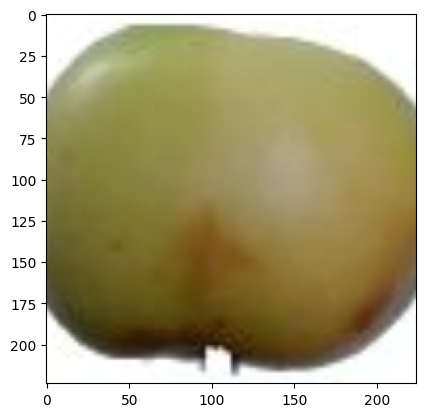

In [0]:
# Define a transform that resizes the image to a larger size before cropping and darkens the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a larger size
    transforms.CenterCrop(224),     # Then crop to the desired size
    # transforms.ColorJitter(brightness=0.25),  # Darken the image
    transforms.ToTensor()
])

# Provide the correct path to the training data
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_dataloader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
test_dataloader_aug = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the first batch of images from the dataloader  
images, labels = next(iter(train_dataloader_aug))  
  
# Select the first image in the batch  
image = images[5]  
  
# Convert the PyTorch tensor to a numpy array  
image = np.transpose(image.numpy(), (1, 2, 0))  
  
# Plot the image  
plt.imshow(image)  
plt.show()

Fully Connected Model1: Below model is to modify the fully connected (fc) layer of a pre-trained GoogleNet model in PyTorch by adding layers as below:

First layer is added to the sequential module with 1024 input features and 512 output features.
To reduce non-linearity and improve learning of model on complex patterns, a ReLu activation function is added in second layer to act on the output of the first layer
Third layer is added with drop out to reduce overfitting of the model by randomly dropping out some of the neurons during training for regularization.
Forth layer is added to generate output having total classes = number of classes in original dataset.
Last layer is added to take Log of SoftMax function on probability of the prediction belonging to each class. By doing this, in this baseline model is replacing the original fc layer of the pre-trained GoogleNet model with the new sequential module.

In [0]:
model.fc = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.MaxPool1d(kernel_size=2),
                                 nn.Linear(256, len(class_names)),
                                 nn.Softmax(dim=1)).to(device)

In [0]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

In [0]:
from timeit import default_timer as timer
start_time=timer()
device = "cuda" if torch.cuda.is_available() else "cpu"
results_model_fc=train(model=model,
                    train_dataloader=train_dataloader_aug,
                    test_dataloader=test_dataloader_aug,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5,
                    device=device)
end_time=timer()
print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0| train_loss:4.9482|train_acc:0.0150|test_loss:4.9484|test_acc:0.0041
Epoch:1| train_loss:4.9454|train_acc:0.0161|test_loss:4.9498|test_acc:0.0104
Epoch:2| train_loss:4.9507|train_acc:0.0094|test_loss:4.9500|test_acc:0.0070
Epoch:3| train_loss:4.9481|train_acc:0.0126|test_loss:4.9431|test_acc:0.0139
Epoch:4| train_loss:4.9463|train_acc:0.0145|test_loss:4.9495|test_acc:0.0104
[INFO]Total training time= 8995.584 seconds


# Conclusion on further data augmentation Experiment : 
Compared to the baseline, test_accuracy of this model is pretty low, when it is trained for 5 epochs. So we did not continue this model training further.